In [29]:
import ctypes
libgcc_s = ctypes.CDLL('libgcc_s.so.1')
import warnings
from typing import Union, Dict
from shutil import copyfile
from copy import deepcopy
import inspect
import pickle
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, DeviceStatsMonitor, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from omegaconf import OmegaConf
import os
import argparse
from einops import rearrange
from pytorch_lightning import Trainer, seed_everything
from earthformer.config import cfg
from earthformer.utils.optim import SequentialLR, warmup_lambda
from earthformer.utils.utils import get_parameter_names
from earthformer.utils.checkpoint import pl_ckpt_to_pytorch_state_dict, s3_download_pretrained_ckpt
from earthformer.utils.layout import layout_to_in_out_slice
from earthformer.visualization.nbody import save_example_vis_results
#from earthformer.metrics.sevir import SEVIRSkillScore
from earthformer.cuboid_transformer.cuboid_transformer import CuboidTransformerModel
from earthformer.datasets.LSTM.LSTM_torchlightning_wrap import LSTMLightningDataModule
from earthformer.utils.apex_ddp import ApexDDPStrategy
from pytorch_lightning.utilities.cloud_io import load as pl_load
from einops import rearrange
import math

In [30]:
import pylab as plt
import pandas as pd
def denseScatterHist1200(cp,tp,title):
    r2=np.corrcoef(cp,tp)[1,0]**2
    bias = np.mean(cp-tp)
    rmse = np.sqrt(np.mean((cp-tp)**2))
    nrmse=rmse/np.mean(cp)
    n=cp.shape[0]
    hist, xbins, ybins = np.histogram2d(tp,cp,(100, 100))
    extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()]

    plt.imshow(np.sqrt(np.ma.masked_where(hist == 0, hist).T),cmap='jet', origin='lower', extent=extent)
    ax.tick_params(labelsize=16)
    plt.xlabel('Measured DSR',fontsize=18)
    plt.ylabel('Estimated DSR',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.yticks(np.arange(0,1.2,0.1))
    plt.plot(np.arange(0,1.21, 0.1),np.arange(0,1.21, 0.1),'r')
    plt.axis([0,1.210,0,1.210])
    plt.text(0.1,0.87,'$R^2$={:.3f}\nBias={:.2f}\nRMSE={:.1f}\nrRMSE={:.1f}\nn={:}'.format(r2,bias,rmse,nrmse*100,n),fontsize=18)
    plt.title(title, size=20)
    #fig.savefig('/gpfs/data1/lianggp/lir/'+'instantaneous.png',bbox_inches = 'tight',dpi=600)
    return r2,bias,rmse,nrmse,n

In [39]:
# input_fc=4
# output_fc=4
# orgi_fc=8
# szamode='refdeduct'
# tile='h15v04'
# time_res='1h'
# data_source='geonex'

input_fc=8
output_fc=12
orgi_fc=24
szamode='exrefdeduct'
tl=''
ttm=''
tile='h15v04'
time_res='15min'
data_source='lstm'


raw_folder = '/gpfs/data1/lianggp/lir/forcast/'
processed_folder = 'data/'
train_test_file = data_source+'_generated_'+szamode+'_'+tile+tl+'_'+str(orgi_fc)+'_'+time_res+ttm+'_train_test_data_earthformer.npz'
save_results=raw_folder+'process_results/earthformer/'+train_test_file[:-4]+'/'
if not os.path.exists(save_results):
    print('jj')
    os.makedirs(save_results, exist_ok=True)


jj


## test original file

In [40]:
df_test=np.load(os.path.join(raw_folder, processed_folder, train_test_file), allow_pickle=True)['arr_3']
df_test = pd.DataFrame(df_test, columns = ['ids', 'iH', 'iV', 'Doy', 'time_id', 'tile_id', 'train'])
df_test

,ids,iH,iV,Doy,time_id,tile_id,train
0,3327,15,4,71,20,4,0
1,1849,15,4,46,15,2,0
2,13176,15,4,183,24,1,0
3,3248,15,4,70,18,1,0
4,14776,15,4,199,14,1,0
...,...,...,...,...,...,...,...
3652,10743,15,4,158,11,4,0
3653,8444,15,4,134,19,1,0
3654,11740,15,4,169,3,1,0
3655,701,15,4,21,13,2,0


In [41]:
a=np.load(os.path.join( 'experiments/lstm/checkpoints/prediction',train_test_file[:-4]+'_'+str(input_fc)+'_'+str(output_fc)+'_prediction.npz'),allow_pickle=True)
y=a['arr_0']
for i in range(len(y)):
    y[i]=y[i].numpy()
y_pred=np.concatenate(y, axis=0 )
y_pred.shape

(3657, 12, 60, 60, 1)

In [42]:
X_test = np.load(os.path.join(raw_folder, processed_folder, train_test_file))['arr_1']
X_test.shape

(3657, 24, 60, 60, 1)

In [43]:
y_test=X_test[:,input_fc:input_fc+output_fc,:,:,:]
y_test.shape

(3657, 12, 60, 60, 1)

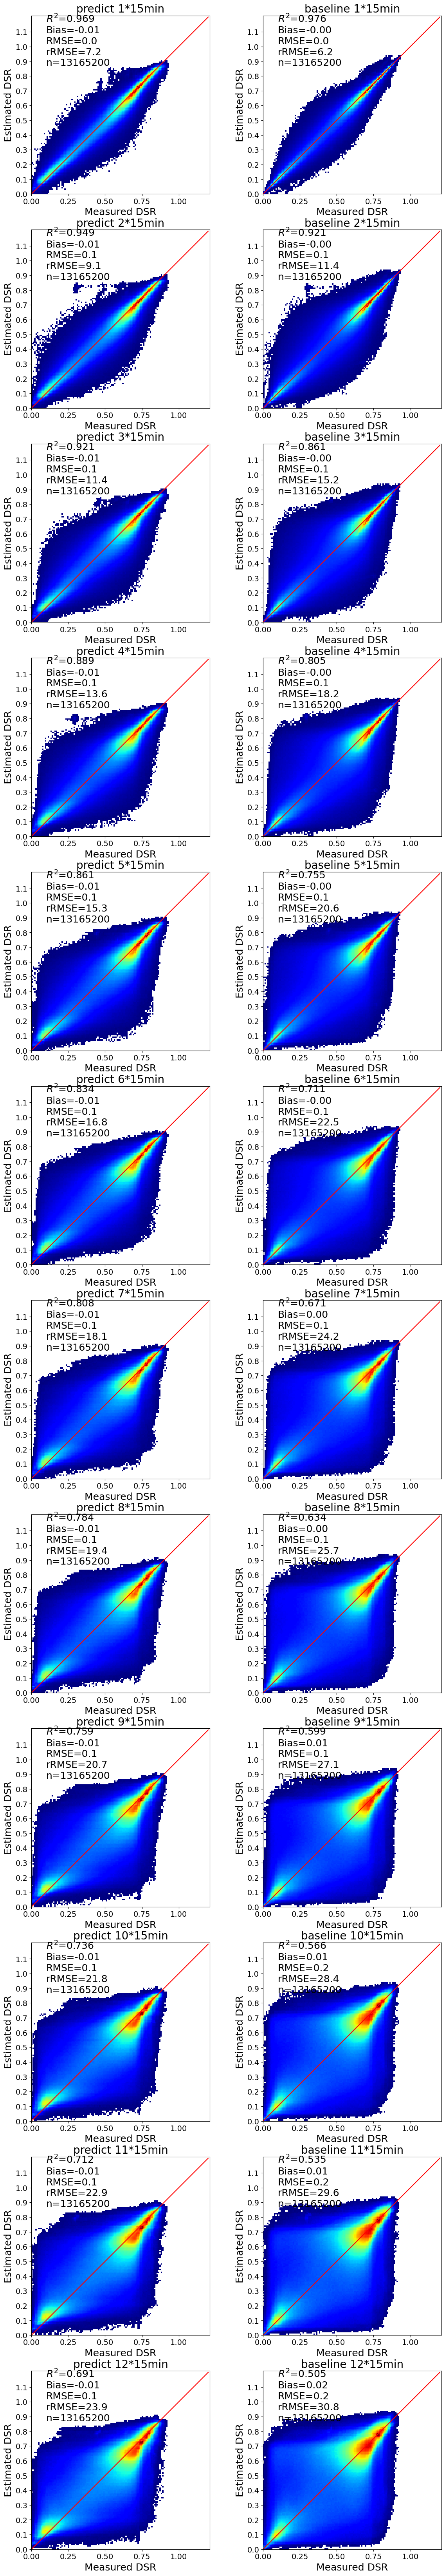

In [44]:
fig=plt.figure(figsize=(14,7*(output_fc)))
for i in range(output_fc):
    ax = plt.subplot(output_fc,2,(2*(i))+1)
    predict=y_pred[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    denseScatterHist1200(predict,true,'predict '+str(i+1)+'*'+time_res)
for i in range(output_fc):
    ax = plt.subplot(output_fc,2,(2*(i))+2)
    predict=X_test[:,input_fc-1,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    denseScatterHist1200(predict,true,'baseline '+str(i+1)+'*'+time_res)
fig.savefig(save_results+'/'+train_test_file[:-4]+'_image_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)

## test new files

In [8]:
tile='h15v04'
tl='_tl'

raw_folder = '/gpfs/data1/lianggp/lir/forcast/'
processed_folder = 'data/'
train_test_file = data_source+'_generated_'+szamode+'_'+tile+tl+'_'+str(orgi_fc)+'_'+time_res+'_train_test_data_earthformer.npz'
print(train_test_file)

lstm_generated_exrefdeduct_h15v04_tl_24_15min_train_test_data_earthformer.npz


In [9]:
df_test=np.load(os.path.join(raw_folder, processed_folder, train_test_file), allow_pickle=True)['arr_3']
df_test = pd.DataFrame(df_test, columns = ['ids', 'iH', 'iV', 'Doy', 'time_id', 'tile_id', 'train'])
df_test

,ids,iH,iV,Doy,time_id,tile_id,train
0,4204,15,4,85,20,1,0
1,3106,15,4,70,17,3,0
2,18895,15,4,257,17,4,0
3,18156,15,4,248,4,1,0
4,18260,15,4,249,11,1,0
...,...,...,...,...,...,...,...
4658,12255,15,4,178,20,4,0
4659,23222,15,4,359,15,3,0
4660,18421,15,4,251,12,2,0
4661,6065,15,4,110,13,2,0


In [10]:
a=np.load(os.path.join( 'experiments/lstm/checkpoints/prediction',train_test_file[:-4]+'_'+str(input_fc)+'_'+str(output_fc)+'_test_prediction.npz'),allow_pickle=True)
y=a['arr_0']
for i in range(len(y)):
    y[i]=y[i].numpy()
y_pred=np.concatenate(y, axis=0 )
y_pred.shape

(4663, 8, 60, 60, 1)

In [11]:
X_test = np.load(os.path.join(raw_folder, processed_folder, train_test_file))['arr_1']
X_test.shape

(4663, 24, 60, 60, 1)

In [12]:
y_test=X_test[:,input_fc:input_fc+output_fc,:,:,:]
y_test.shape

(4663, 8, 60, 60, 1)

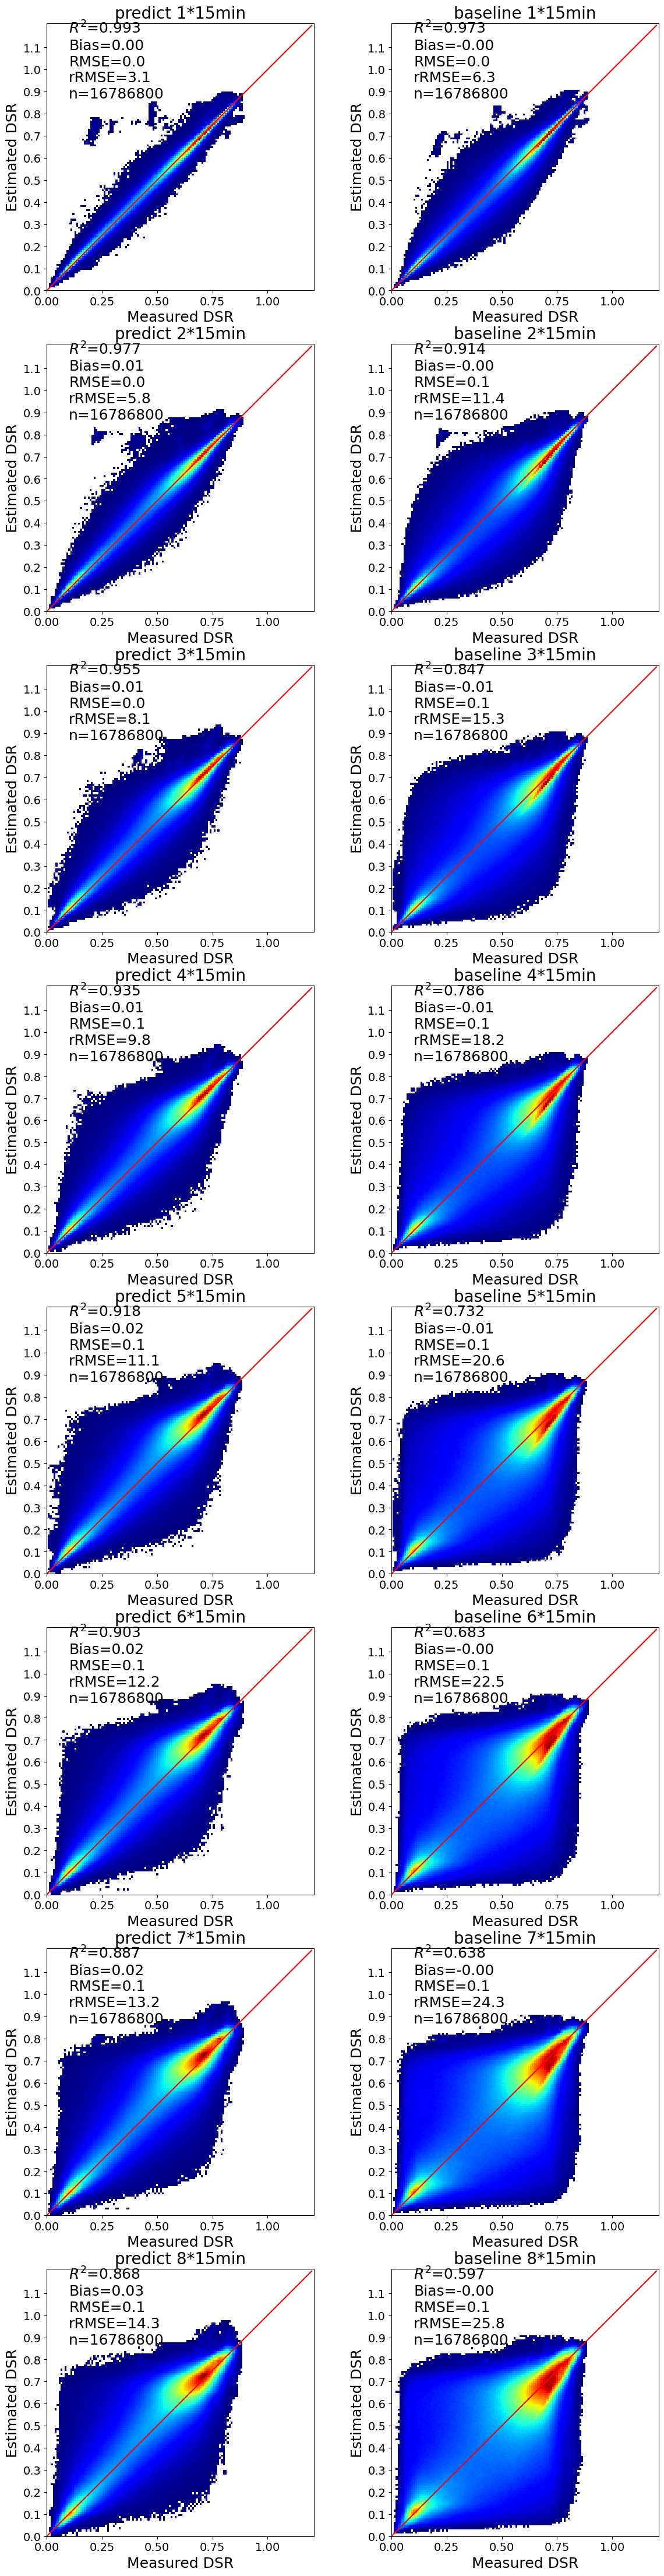

In [13]:
fig=plt.figure(figsize=(14,7*(output_fc)))
for i in range(output_fc):
    ax = plt.subplot(output_fc,2,(2*(i))+1)
    predict=y_pred[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    denseScatterHist1200(predict,true,'predict '+str(i+1)+'*'+time_res)
for i in range(output_fc):
    ax = plt.subplot(output_fc,2,(2*(i))+2)
    predict=X_test[:,input_fc-1,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    denseScatterHist1200(predict,true,'baseline '+str(i+1)+'*'+time_res)
fig.savefig(save_results+'/'+train_test_file[:-4]+'_image_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)